<a href="https://colab.research.google.com/github/MaksimReznicenko/Maksim_Reznichenko/blob/main/PE8_1_%22FineTuning_general_%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Скачиваем датасет с Kaggle, распаковываем архив

In [ ]:
# Install Kaggle package
!pip install kaggle >> None

# Upload Kaggle API token (you need to have a kaggle.json file with your Kaggle API credentials)
from google.colab import files
files.upload()

# Create a Kaggle folder and move the kaggle.json file there
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Change the permissions of the file
!chmod 600 ~/.kaggle/kaggle.json

# Download the Rock Paper Scissors dataset from Kaggle
!kaggle datasets download -d sanikamal/rock-paper-scissors-dataset

# Unzip the dataset
!unzip rock-paper-scissors-dataset.zip

In [ ]:
# Now, let's prepare the dataset for training and validation
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
data_dir = 'Rock-Paper-Scissors'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

# Create train and val directories
if not os.path.exists(val_dir):
    os.makedirs(val_dir)
    for class_name in ['rock', 'paper', 'scissors']:
        os.makedirs(os.path.join(val_dir, class_name))

# Move validation images from 'validation' to 'val'
for class_name in ['rock', 'paper', 'scissors']:
    src_class_dir = os.path.join(data_dir, 'val', class_name)
    dst_class_dir = os.path.join(val_dir, class_name)
    if os.path.exists(src_class_dir):
        for img in os.listdir(src_class_dir):
            shutil.move(os.path.join(src_class_dir, img), os.path.join(dst_class_dir, img))

print("Dataset preparation complete.")


# Приводим данные к нужному формату, добавляем аугментации

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import time
import os
import copy

from tqdm import tqdm

from torch.optim import lr_scheduler

# Define transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # приведение к одному размеру
        transforms.RandomHorizontalFlip(), # аугментация - отзеркаливание
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # нормализация по каналам
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'Rock-Paper-Scissors'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Running model on ', device)

['scissors', 'paper', 'rock']

# Визуализируем датасет

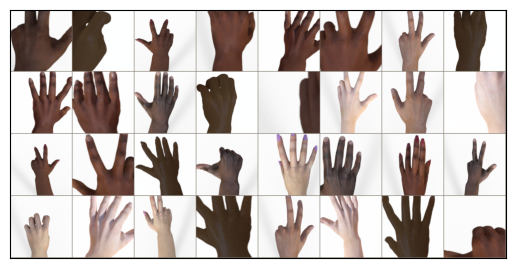

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Function to show images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.xticks([])  # Remove x-ticks
    plt.yticks([])  # Remove y-ticks
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# Plot the images
imshow(out, title=[class_names[x] for x in classes])


# Прописываем общую функцию для обучения

In [ ]:
# Function to train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model

# Задаем две модели - с нуля и предобученную. У предобученной замораживаем веса, запускаем их обучение

In [ ]:
# Load ResNet-18 model trained from scratch
model_ft_scratch = models.resnet18(pretrained=False) # НЕ предобученная модель (pretrained=False)
num_ftrs = model_ft_scratch.fc.in_features
model_ft_scratch.fc = nn.Linear(num_ftrs, len(class_names)) # задаем 3 класса на выходе
model_ft_scratch = model_ft_scratch.to(device)

criterion = nn.CrossEntropyLoss() # Задаем функцию потерь

optimizer_ft_scratch = optim.SGD(model_ft_scratch.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler_scratch = lr_scheduler.StepLR(optimizer_ft_scratch, step_size=7, gamma=0.1)

# Запускаем обучение на 5 эпох
print("Training ResNet-18 from scratch")
model_ft_scratch = train_model(model_ft_scratch, criterion, optimizer_ft_scratch, exp_lr_scheduler_scratch, num_epochs=5)

# Задаем предобученную на ImageNet модель.
model_ft_pretrained = models.resnet18(weights='IMAGENET1K_V1')

# Замораживаем все слои модели
for param in model_ft_pretrained.parameters():
    param.requires_grad = False

num_ftrs = model_ft_pretrained.fc.in_features
model_ft_pretrained.fc = nn.Linear(num_ftrs, len(class_names)) # При перезаписи, новый слой будет "разморожен"
model_ft_pretrained = model_ft_pretrained.to(device) # Отправляем на GPU

# Указываем оптимизатору, что только последний слой надо обновлять
optimizer_ft_pretrained = optim.SGD(model_ft_pretrained.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler_pretrained = lr_scheduler.StepLR(optimizer_ft_pretrained, step_size=7, gamma=0.1)

# Запускаем обучение на 5 эпох
print("Fine-tuning pretrained ResNet-18")
model_ft_pretrained = train_model(model_ft_pretrained, criterion, optimizer_ft_pretrained, exp_lr_scheduler_pretrained, num_epochs=5)


Running model on  cuda:0
Training ResNet-18 from scratch
Epoch 0/4
----------


100%|██████████| 79/79 [00:14<00:00,  5.45it/s]


train Loss: 0.9946 Acc: 0.4937


100%|██████████| 12/12 [00:01<00:00,  6.04it/s]


test Loss: 1.2790 Acc: 0.3333
Epoch 1/4
----------


100%|██████████| 79/79 [00:14<00:00,  5.40it/s]


train Loss: 0.7066 Acc: 0.7286


100%|██████████| 12/12 [00:01<00:00,  6.06it/s]


test Loss: 0.9481 Acc: 0.4113
Epoch 2/4
----------


100%|██████████| 79/79 [00:14<00:00,  5.48it/s]


train Loss: 0.4940 Acc: 0.8222


100%|██████████| 12/12 [00:01<00:00,  6.09it/s]


test Loss: 0.8792 Acc: 0.5618
Epoch 3/4
----------


100%|██████████| 79/79 [00:14<00:00,  5.35it/s]


train Loss: 0.3773 Acc: 0.8552


100%|██████████| 12/12 [00:01<00:00,  6.00it/s]


test Loss: 1.5286 Acc: 0.4677
Epoch 4/4
----------


100%|██████████| 79/79 [00:14<00:00,  5.43it/s]


train Loss: 0.3407 Acc: 0.8750


100%|██████████| 12/12 [00:01<00:00,  6.17it/s]


test Loss: 1.5048 Acc: 0.6559
Training complete in 1m 23s
Best val Acc: 0.6559
Fine-tuning pretrained ResNet-18
Epoch 0/4
----------


100%|██████████| 79/79 [00:13<00:00,  5.88it/s]


train Loss: 0.7272 Acc: 0.7167


100%|██████████| 12/12 [00:01<00:00,  6.06it/s]


test Loss: 0.5158 Acc: 0.8306
Epoch 1/4
----------


100%|██████████| 79/79 [00:13<00:00,  5.98it/s]


train Loss: 0.4377 Acc: 0.8667


100%|██████████| 12/12 [00:02<00:00,  5.88it/s]


test Loss: 0.4037 Acc: 0.8710
Epoch 2/4
----------


100%|██████████| 79/79 [00:13<00:00,  6.02it/s]


train Loss: 0.3885 Acc: 0.8579


100%|██████████| 12/12 [00:01<00:00,  6.03it/s]


test Loss: 0.3669 Acc: 0.8548
Epoch 3/4
----------


100%|██████████| 79/79 [00:13<00:00,  5.97it/s]


train Loss: 0.3462 Acc: 0.8766


100%|██████████| 12/12 [00:01<00:00,  6.08it/s]


test Loss: 0.3062 Acc: 0.9274
Epoch 4/4
----------


100%|██████████| 79/79 [00:13<00:00,  5.93it/s]


train Loss: 0.3307 Acc: 0.8833


100%|██████████| 12/12 [00:01<00:00,  6.15it/s]

test Loss: 0.3167 Acc: 0.8763
Training complete in 1m 16s
Best val Acc: 0.9274


# Выводы

### Обучение с нуля:

Время: 1m23s

Best val Acc: 0.6559

### Дообучение:

Время: 1m16s

Best val Acc: 0.9274